In [1]:
%matplotlib widget
# %matplotlib inline

import numpy as np
import cmath
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../../

import pylib.mix as mix
import kvn
import pylib.Chebyschev_coefs as ch
import pylib.qucf_read as qucf_r
import pylib.measurement as mse

32670
/media/work/docs/codes/QuCF/scripts-py


In [2]:
# ---------------------------------------------------------------------------------------------------
# --- Some global parameters ---
# ---------------------------------------------------------------------------------------------------
colors_ = ["b", "r", "g", "magenta", "black"]
path_save_ = "./jupyter-notebooks/NL/results/"
path_qucf_ = "../QuCF/simulations/LCHS/KvN/BE-2/"
for _ in range(100):
    plt.close()

In [3]:
# ---------------------------------------------------------------------------------------------------
# --- Prepare initial parameters ---
# ---------------------------------------------------------------------------------------------------
mix.reload_module(kvn)

# --- two attractors ---
F_ = lambda x:  - np.sin(x) * (np.sin(x)**2 - 0.25)
# ----------------------------------------

nx_ = 7
nk_    = 7
k_max_ = 10
flag_Cheb_ = True

# --- Linear x-grid ---
Nx_ = 1 << nx_
x_lin_ = np.linspace(-1.0, 1.0, Nx_)  
dx_    = np.diff(x_lin_)[0]
print("nx: {:d}".format(nx_))

# --- k-grid ---
Nk_    = 1 << nk_
k_     = np.linspace(-k_max_, k_max_, Nk_)
dk_    = np.diff(k_)[0]

_, Aa_, Ah_, Aa_qsvt_, Ah_qsvt_ = kvn.construct_UW_matrix_1D(
    x_lin_, F_, 
    flag_asin = False, flag_Cheb = flag_Cheb_, flag_sin = False
)

# --- LCHS matrices ---
Ba_, Bm_, Bk_, norm_a_x, norm_m_x, norm_k_x = \
    kvn.compute_norm_matrices_LCHS_with_output_norm(Aa_, Ah_, k_max_, dk_)
print("\n---")
Ba_qsvt_, Bm_qsvt_, Bk_qsvt_, norm_a_qsvt, norm_m_qsvt, norm_k_qsvt = \
    kvn.compute_norm_matrices_LCHS_with_output_norm(Aa_qsvt_, Ah_qsvt_, k_max_, dk_)

# --- Rescale matrices to the BULK elements of the D-matrices ---
# rescaling at the edge should be corrected afterwards
dd_diags_ref_  = kvn.get_rescaled_diags_BE(Ba_, Bm_, Bk_)
dd_diags_qsvt_ = kvn.get_rescaled_diags_BE(Ba_qsvt_, Bm_qsvt_, Bk_qsvt_)

nx: 7
Matrix Ba:	 nonsparsity, coefnorm: 2, 3.319e+01
Matrix B_kmax:	 nonsparsity, coefnorm: 3, 8.622e+02
Matrix Bk:	 nonsparsity, coefnorm: 3, 1.358e+01

norm of Ba_norm_:     0.500
norm of B_kmax_norm_: 0.333
norm of Bk_norm_:     0.333

---
Matrix Ba:	 nonsparsity, coefnorm: 2, 3.454e+01
Matrix B_kmax:	 nonsparsity, coefnorm: 3, 8.976e+02
Matrix Bk:	 nonsparsity, coefnorm: 3, 1.414e+01

norm of Ba_norm_:     0.500
norm of B_kmax_norm_: 0.333
norm of Bk_norm_:     0.333



-------------------------------------------------------------------------
--- Ba-norm ---


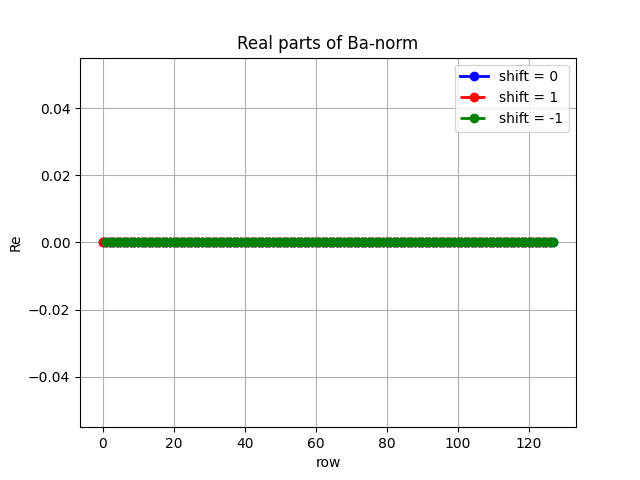

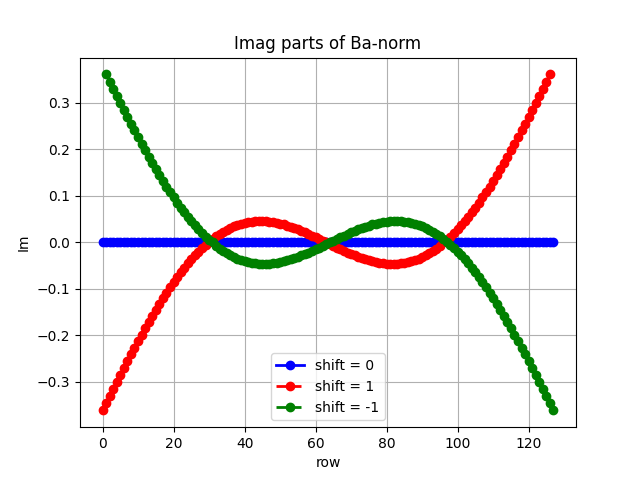


-------------------------------------------------------------------------
--- B-kmax-norm ---


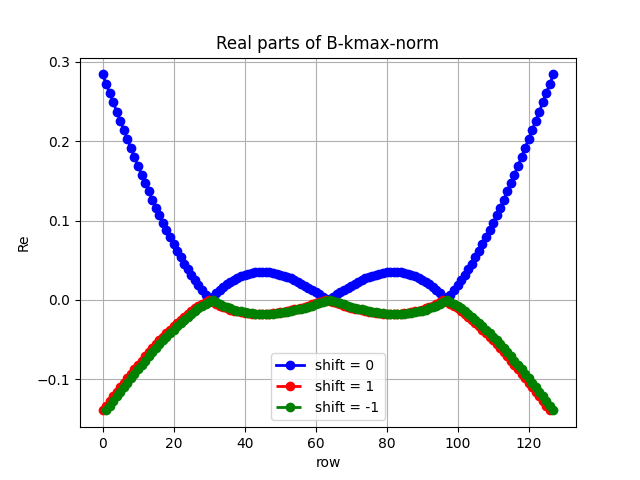

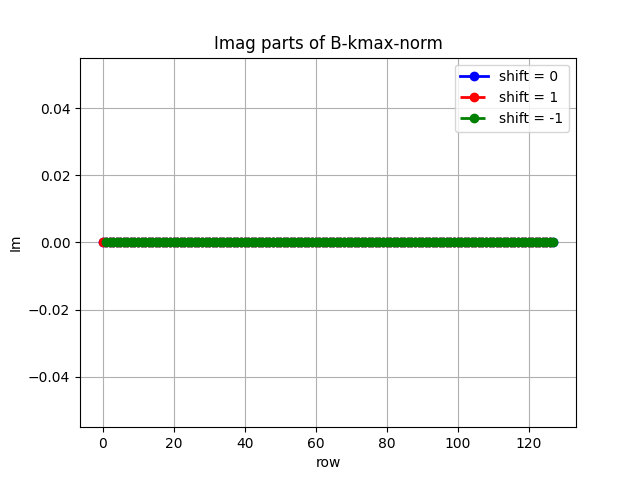

In [16]:
# ---------------------------------------------------------------
# --- Print diagonals of normalized (non-rescaled) matrices ---
# ---------------------------------------------------------------
mix.reload_module(kvn)
def get_plot_diags(flag_save):
    print()
    print("-------------------------------------------------------------------------")
    print("--- Ba-norm ---")
    A_plot, A_name, flag_save_real = Ba_,     "Ba-norm",     False
    kvn.plot_save_diagonals(A_plot, A_name, flag_save, flag_save_real, path_save_)

    print()
    print("-------------------------------------------------------------------------")
    print("--- B-kmax-norm ---")
    A_plot, A_name, flag_save_real = Bk_, "B-kmax-norm", True
    kvn.plot_save_diagonals(A_plot, A_name, flag_save, flag_save_real, path_save_)
    del flag_save, A_plot, A_name, flag_save_real
    return
# ------------------------------------------------------------------
get_plot_diags(flag_save = False)

In [4]:
# -----------------------------------------------------------
# --- Choose the MATRIX and Compute normalized SUMS ---
# -----------------------------------------------------------
mix.reload_module(kvn)

ratio_norms_k_ = norm_k_qsvt/norm_k_x
ratio_norms_a_ = norm_a_qsvt/norm_a_x
print("Bk: norm_asin / norm_x: {:0.3e}".format(ratio_norms_k_))
print("Ba: norm_asin / norm_x: {:0.3e}".format(ratio_norms_a_))

# --- Sums over Chebyschev roots ---
ar_sD, ar_sR, ar_RR, ar_CR, ar_RL, ar_CL, sum_D, sum_R_k, sum_L_k, sum_R_a, sum_L_a \
   = kvn.get_sums_UW_KvN_LCHS_matrices_norm(
      x_lin_, F_, norm_a_x, norm_k_x, dk_,
      flag_asin = False, flag_Cheb = flag_Cheb_, flag_sin = False
   )

# --- Sums over linear spatial grid ---
ar_sD_x, ar_sR_x, ar_RR_x, ar_CR_x, ar_RL_x, ar_CL_x, sum_D_x, sum_R_k_x, sum_L_k_x, sum_R_a_x, sum_L_a_x \
   = kvn.get_sums_UW_KvN_LCHS_matrices_norm(
      x_lin_, F_, norm_a_x, norm_k_x, dk_,
      flag_asin = False, flag_Cheb = False, flag_sin = False
   )

# --- Row indices ---
row_D = range(Nx_)
row_R = range(Nx_-1)
row_L = range(1,Nx_)

Bk: norm_asin / norm_x: 1.041e+00
Ba: norm_asin / norm_x: 1.041e+00


sign-D:   eb, ids: 1,  [30, 63, 96]
delta-RR: eb, ids: 0,  [30, 63, 96]
delta-CR: eb, ids: 1,  [29, 62, 95]
delta-RL: eb, ids: 1,  [30, 63, 96]
delta-CL: eb, ids: 0,  [31, 64, 97]


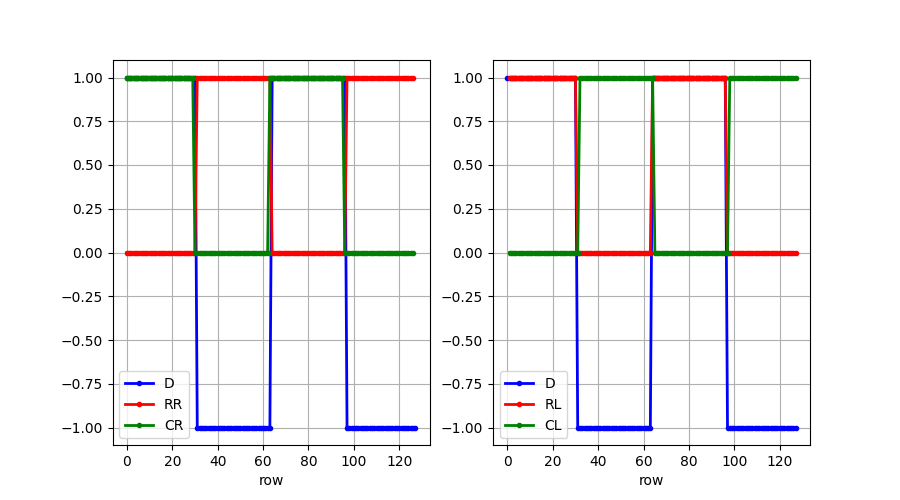

In [5]:
# -------------------------------------------------------------
# --- Plot signs and delta-functions ---
# -------------------------------------------------------------
mix.reload_module(kvn)
def plot_signs_delta(flag_x = False):
    def comp_ids(arr, id_sh = 0):
        temp = arr[0]
        ids_res = []  # indices AFTER each the considered array changes value
        for ix in range(len(arr)):
            if arr[ix] != temp:
                temp = arr[ix]
                ids_res.append(ix - 1 + id_sh)
        return ids_res
    # ---------------------------------------------

    if flag_x:
        ar_sD_curr = np.array(ar_sD_x)
        ar_RR_curr = np.array(ar_RR_x)
        ar_CR_curr = np.array(ar_CR_x)
        ar_RL_curr = np.array(ar_RL_x)
        ar_CL_curr = np.array(ar_CL_x)
    else:
        ar_sD_curr = np.array(ar_sD)
        ar_RR_curr = np.array(ar_RR)
        ar_CR_curr = np.array(ar_CR)
        ar_RL_curr = np.array(ar_RL)
        ar_CL_curr = np.array(ar_CL)


    # --- Find indices ---
    ids_D  = comp_ids(ar_sD_curr)
    ids_RR = comp_ids(ar_RR_curr)
    ids_CR = comp_ids(ar_CR_curr)
    ids_RL = comp_ids(ar_RL_curr, 1)
    ids_CL = comp_ids(ar_CL_curr, 1)
    print("sign-D:   eb, ids: {:d}, ".format(int(ar_sD_curr[0])), ids_D)
    print("delta-RR: eb, ids: {:d}, ".format(int(ar_RR_curr[0])), ids_RR) # = ids_D
    print("delta-CR: eb, ids: {:d}, ".format(int(ar_CR_curr[0])), ids_CR) # = ids_D - 1
    print("delta-RL: eb, ids: {:d}, ".format(int(ar_RL_curr[0])), ids_RL) # = ids_D
    print("delta-CL: eb, ids: {:d}, ".format(int(ar_CL_curr[0])), ids_CL) # = ids_D + 1


    # --- Plotting ---
    fig = plt.figure(figsize=(9,5))
    ax = fig.add_subplot(121)
    ax.plot(row_D,  ar_sD_curr, color='b', marker = ".", linewidth = 2, linestyle='-', label = "D")
    ax.plot(row_R,  ar_RR_curr, color='r', marker = ".", linewidth = 2, linestyle='-', label = "RR")
    ax.plot(row_R,  ar_CR_curr, color='g', marker = ".", linewidth = 2, linestyle='-', label = "CR")
    plt.xlabel('row')
    plt.legend()
    plt.grid(True)

    ax = fig.add_subplot(122)
    ax.plot(row_D,  ar_sD_curr, color='b', marker = ".", linewidth = 2, linestyle='-', label = "D")
    ax.plot(row_L,  ar_RL_curr, color='r', marker = ".", linewidth = 2, linestyle='-', label = "RL")
    ax.plot(row_L,  ar_CL_curr, color='g', marker = ".", linewidth = 2, linestyle='-', label = "CL")
    plt.xlabel('row')
    plt.legend()
    plt.grid(True)
    plt.show()
    return ids_D
# --------------------------------------------------------------------------------------------
ids_D_signs_ = plot_signs_delta(flag_x = True)

sum: sum_D: -1.332e-15


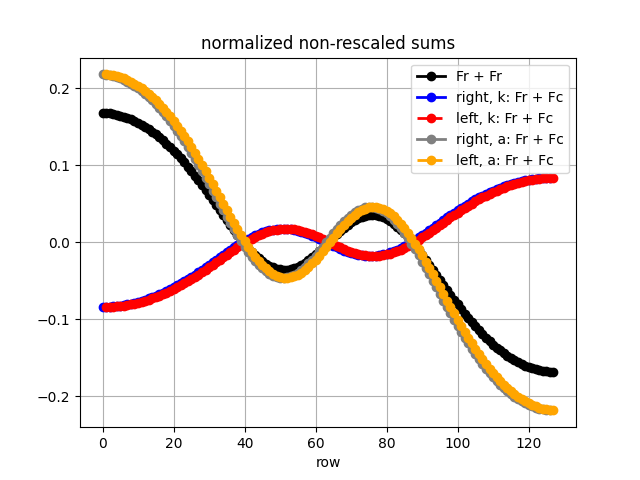

In [7]:
# -------------------------------------------------------------
# --- Plot various sums ---
# -------------------------------------------------------------
mix.reload_module(kvn)
def plot_norm_sums():
    print("sum: sum_D: {:0.3e}".format(np.sum(sum_D)))

    # --- Compara
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(
        row_D,  sum_D, 
        color='black', linewidth = 2, linestyle='-', marker = "o",
        label = "Fr + Fr"
    )

    ax.plot(
        row_R, sum_R_k, 
        color='b', linewidth = 2, linestyle='-', marker = "o",
        label = "right, k: Fr + Fc"
    )
    ax.plot(
        row_L, sum_L_k, 
        color='r', linewidth = 2, linestyle='--', marker = "o",
        label = "left, k: Fr + Fc"
    )  # the same as sum_RR for real F

    ax.plot(
        row_R, sum_R_a, 
        color='gray', linewidth = 2, linestyle='-', marker = "o",
        label = "right, a: Fr + Fc"
    )
    ax.plot(
        row_L, sum_L_a, 
        color='orange', linewidth = 2, linestyle='--', marker = "o",
        label = "left, a: Fr + Fc"
    )  # the same as sum_RL for real F

    plt.xlabel('row')
    plt.legend()
    plt.title("normalized non-rescaled sums")
    plt.grid(True)
    plt.show()
    return
# -------------------------------------------------------------------------
plot_norm_sums()

take Bk_asin.real


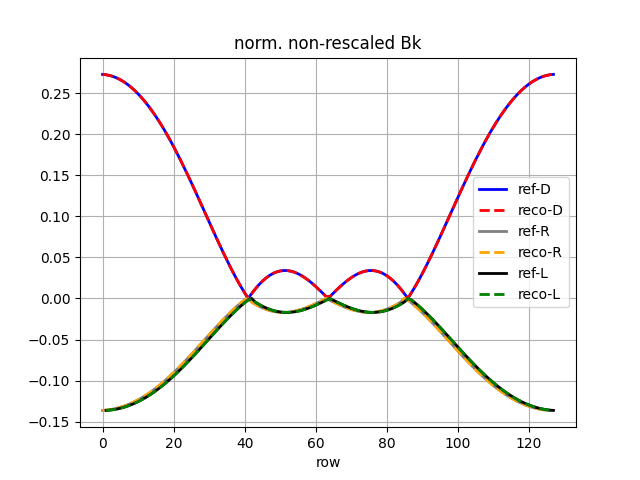

D: ref - reco: 5.551e-17
R: ref - reco: 2.776e-17
L: ref - reco: 2.776e-17


In [6]:
# ------------------------------------------------------------------------------------------
# --- Reconstruct normalized non-rescaled diagonals from the sums (over Chebyschev roots) ---
# -------------------------------------------------------------------------------------------
mix.reload_module(kvn)
def reconstruct_norm_diags(sel_matrix):
    diag_D, diag_R, diag_L = \
        kvn.select_matrix_norm_nonresc_diags(sel_matrix, True, Ba_qsvt_, Bk_qsvt_, Ba_, Bk_)

    # anti-Hermitian part of the matrix (assume that we conside the imaginary part):
    if sel_matrix == "Ba":
        diag_D_reco = np.zeros(Nx_)
        diag_R_reco = - (ar_RR * sum_R_a + ar_CR * sum_R_a) / ratio_norms_a_ 
        diag_L_reco =   (ar_RL * sum_L_a + ar_CL * sum_L_a) / ratio_norms_a_ 

    # Hermitian part of the matrix:
    else:
        diag_D_reco = sum_D * ar_sD / ratio_norms_k_
        diag_R_reco = (- ar_RR * sum_R_k + ar_CR * sum_R_k) / ratio_norms_k_ 
        diag_L_reco =   (ar_RL * sum_L_k - ar_CL * sum_L_k) / ratio_norms_k_ 

    # --- Plotting the diagonals ---
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(row_D, diag_D,      '-b', linewidth = 2, label = "ref-D")
    ax.plot(row_D, diag_D_reco, '--r', linewidth = 2, label = "reco-D")

    ax.plot(row_R, diag_R,     color='gray',   linewidth = 2, linestyle='-',  label = "ref-R")
    ax.plot(row_R, diag_R_reco, color='orange', linewidth = 2, linestyle='--', label = "reco-R")

    ax.plot(row_L, diag_L,     color='black', linewidth = 2, linestyle='-',  label = "ref-L")
    ax.plot(row_L, diag_L_reco, color='green', linewidth = 2, linestyle='--', label = "reco-L")

    plt.xlabel('row')
    plt.title("norm. non-rescaled " + sel_matrix)
    plt.legend()
    plt.grid(True)
    plt.show()

    print("D: ref - reco: {:0.3e}".format(np.max(np.abs(diag_D - diag_D_reco))))
    print("R: ref - reco: {:0.3e}".format(np.max(np.abs(diag_R - diag_R_reco))))
    print("L: ref - reco: {:0.3e}".format(np.max(np.abs(diag_L - diag_L_reco))))
    return
# -----------------------------------------------------------------------------------------
reconstruct_norm_diags(sel_matrix = "Bk") # "Ba" or "Bk"

In [6]:
# ---------------------------------------------------------------------
# --- GET rescaled sums (because of the influence of the OF oracle) ---
# --- Here, the rescaling is performed only to bulk points          ---
# ---------------------------------------------------------------------
def get_rescaled_sums():
    # rescaled sums for Bk:
    coef_R_k, coef_D = 0.250, 0.500
    sum_D_rs   = sum_D   / coef_D
    sum_R_k_rs = sum_R_k / coef_R_k

    # rescaled sum for Ba:
    coef_R_a = 0.500
    sum_R_a_rs   = sum_R_a / coef_R_a

    # ---
    sum_D_x_rs   = sum_D_x   / coef_D
    sum_R_k_x_rs = sum_R_k_x / coef_R_k
    sum_R_a_x_rs = sum_R_a_x / coef_R_a
    return sum_D_rs, sum_R_k_rs, sum_R_a_rs, sum_D_x_rs, sum_R_k_x_rs, sum_R_a_x_rs
# ----------------------------------------------------------------------------
sum_D_rs, sum_R_k_rs, sum_R_a_rs, sum_D_x_rs, sum_R_k_x_rs, sum_R_a_x_rs = get_rescaled_sums()

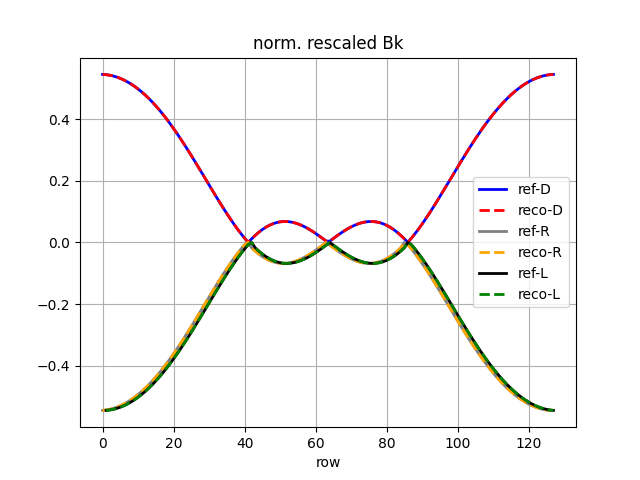

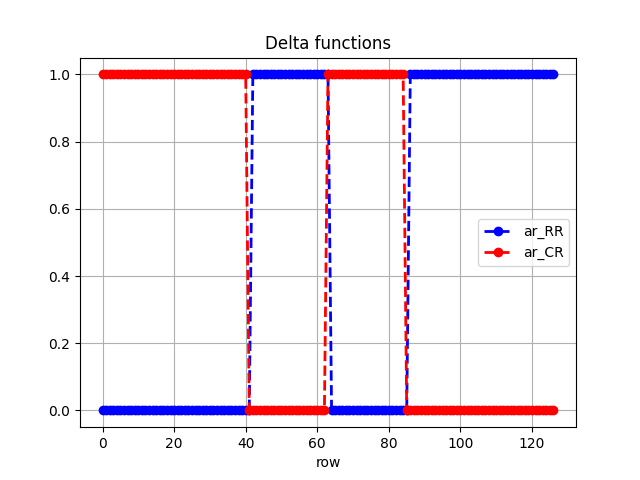

D: ref - reco: 1.110e-16
R: ref - reco: 1.110e-16
L: ref - reco: 1.110e-16


In [7]:
# -------------------------------------------------------------------------------------------
# --- Reconstruct normalized rescaled diagonals from the sums (over the Chebyschev roots) ---
# -------------------------------------------------------------------------------------------
def reconstruct_norm_rescaled_diags(sel_matrix):
    # anti-Hermitian part of the matrix (assume that we conside the imaginary part):
    if sel_matrix == "Ba":
        diag_D_reco = np.zeros(Nx_)
        diag_R_reco = - (ar_RR * sum_R_a_rs + ar_CR * sum_R_a_rs) / ratio_norms_a_
        diag_L_reco =   (ar_RL * sum_R_a_rs + ar_CL * sum_R_a_rs) / ratio_norms_a_

        diag_D_ref = np.zeros(Nx_)
        diag_R_ref = dd_diags_qsvt_["diag_A_p1"]
        diag_L_ref = dd_diags_qsvt_["diag_A_m1"]

    # Hermitian part of the matrix:
    else:
        diag_D_reco = sum_D_rs * ar_sD / ratio_norms_k_
        diag_R_reco = (- ar_RR * sum_R_k_rs + ar_CR * sum_R_k_rs) / ratio_norms_k_
        diag_L_reco =   (ar_RL * sum_R_k_rs - ar_CL * sum_R_k_rs) / ratio_norms_k_

        diag_D_ref = dd_diags_qsvt_["diag_k_00"]
        diag_R_ref = dd_diags_qsvt_["diag_k_p1"]
        diag_L_ref = dd_diags_qsvt_["diag_k_m1"]

            
    # --- Plotting the diagonals ---
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(row_D, diag_D_ref,      '-b', linewidth = 2, label = "ref-D")
    ax.plot(row_D, diag_D_reco, '--r', linewidth = 2, label = "reco-D")

    ax.plot(row_R, diag_R_ref,  color='gray',   linewidth = 2, linestyle='-',  label = "ref-R")
    ax.plot(row_R, diag_R_reco, color='orange', linewidth = 2, linestyle='--', label = "reco-R")

    ax.plot(row_L, diag_L_ref,  color='black', linewidth = 2, linestyle='-',  label = "ref-L")
    ax.plot(row_L, diag_L_reco, color='green', linewidth = 2, linestyle='--', label = "reco-L")

    plt.xlabel('row')
    plt.title("norm. rescaled " + sel_matrix)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # --- Plotting the delta ---
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(row_R, ar_RR, '--b', marker = "o", linewidth = 2, label = "ar_RR")
    ax.plot(row_R, ar_CR, '--r', marker = "o", linewidth = 2, label = "ar_CR")

    plt.xlabel('row')
    plt.title("Delta functions")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # --- errors ---
    print("D: ref - reco: {:0.3e}".format(np.max(np.abs(diag_D_ref - diag_D_reco))))
    print("R: ref - reco: {:0.3e}".format(np.max(np.abs(diag_R_ref - diag_R_reco))))
    print("L: ref - reco: {:0.3e}".format(np.max(np.abs(diag_L_ref - diag_L_reco))))
    return
# -----------------------------------------------------------------------------------------
reconstruct_norm_rescaled_diags(sel_matrix = "Bk")  # "Ba" or "Bk"

In [8]:
# ----------------------------------------------------------------------
# --- Choose a sum ---
# ----------------------------------------------------------------------
mix.reload_module(kvn)
def get_extr_odd_even_sum():
    print("Taking {:s} sum".format(sel_sum_))
    
    # --- Choose the halfs ---
    if sel_sum_ == "D":
        sum_work = np.array(sum_D_rs)
        diag_ref = np.array(dd_diags_ref_["diag_k_00"])
        sum_x    = np.array(sum_D_x_rs)
    if sel_sum_ == "Rk":
        sum_work = np.array(sum_R_k_rs) 
        diag_ref = np.array(dd_diags_ref_["diag_k_p1"])
        sum_x    = np.array(sum_R_k_x_rs)
    if sel_sum_ == "Ra":
        sum_work = np.array(sum_R_a_rs)
        diag_ref = np.array(dd_diags_ref_["diag_A_p1"])
        sum_x    = np.array(sum_R_a_x_rs)

    print("sum of f_goal: {:0.3e}".format(np.sum(sum_work)))
    return sum_work, sum_x, diag_ref
# ----------------------------------------------------------------------
sel_sum_ = "Ra"  # "D", "Rk", "Ra" (independent of the chosen matrix)
f_goal_, f_goal_x_, diag_ref_ = get_extr_odd_even_sum()

Taking Ra sum
sum of f_goal: -1.887e-15


In [27]:
for _ in range(100):
    plt.close()

norm. qsvt: 9.609e-01

--------------------------------------------------------------------
--- Computing Chebyschev coefficients ---
--------------------------------------------------------------------

--- Main diagonal -----------------------------
Chosen profile: Ra
Chosen parity: 1

Minimization method is used.
Computation status:  0.0848694693195528

Chosen polynomial's degree:	 4
Number of coefficients:		 2
max. abs. error: 3.859e-02


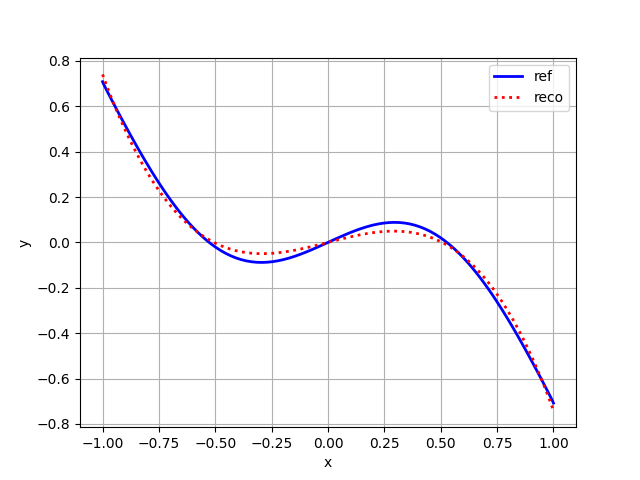

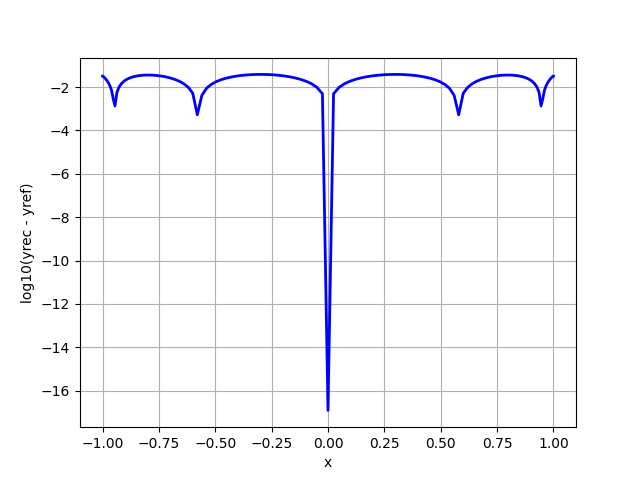

0.7367385394630671
write coefficients to:
 ./jupyter-notebooks/NL/BE/coefs//Ra_nx7_sin_eps1.hdf5

--------------------------------------------------------------------
--- Reconstructed profile ---
--------------------------------------------------------------------


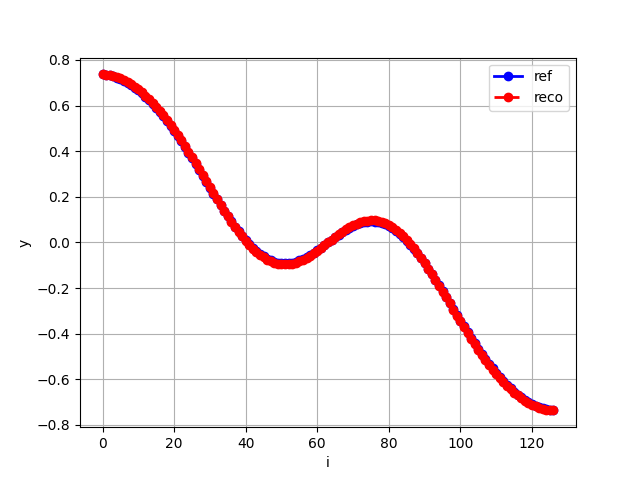

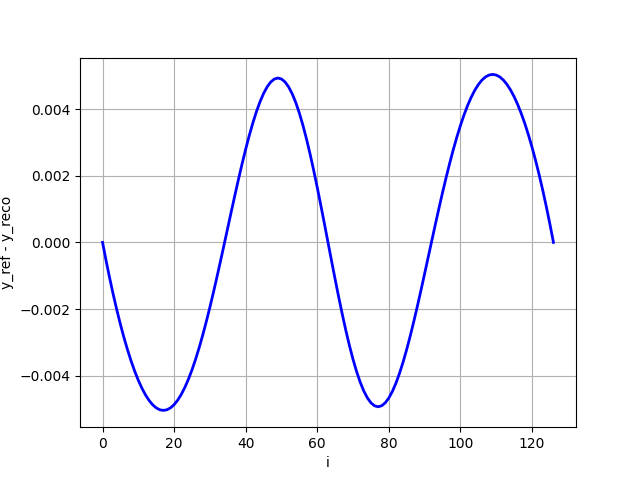

In [15]:
# ---------------------------------------------------------------
# --- Compute QSVT angles for the chosen sum ---
# ---------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(ch)
mix.reload_module(kvn)
def get_Cheb():
    # -----------------------------------------------------------------------------------
    def compute_Cheb_coefs(y, parity_1, Nd, flag_save_hdf5, flag_save_dat):
        sel_method = 0
        if not flag_Cheb_:
            x_loc = np.array(x_lin_)
        else:
            x_loc = ch.get_Cheb_roots(len(y))
        x_loc = np.sin(x_loc)


        





        oo_ch_ = ch.Ch_()
        oo_ch_.choose_method(sel_method)
        oo_ch_.choose_func(
            -1, 0.0, 
            profile_in = y,
            name_prof  = sel_sum_,
            parity_in  = parity_1,
            path_root_in = "./jupyter-notebooks/NL/BE/coefs/",
            x_grid = x_loc,
            coef_norm = norm_qsvt_
        )
        oo_ch_.compute_Ch(Nd)
        oo_ch_.plot_reconstructed_function()
        oo_ch_.plot_errors()
        # oo_ch_.plot_coefficients()

        print(np.max(np.abs(y)))

        if flag_save_hdf5:
            fname_ch = sel_sum_
            fname_ch += "_nx{:d}_sin".format(nx_)
            oo_ch_.save_coefficients(fname_ch)
        return oo_ch_

    # -----------------------------------------------------------------------------------
    def test_recon_sin(sel_test, oo_temp_ch_1, oo_temp_ch_2, flag_save_err):
        Nx_work = Nx_ - 1
        we = Nx_-1
        if sel_sum_ == "D":
            we = Nx_
            Nx_work = Nx_

        if flag_Cheb_ and sel_test == 'goal_x':
            x_coarse = ch.get_Cheb_roots(Nx_work)
        elif flag_Cheb_ and sel_test == 'diag':
            x_coarse = ch.get_Cheb_roots(Nx_work)
        else:
            x_coarse = np.linspace(-1.0, 1.0, Nx_work)

        x_linear = np.linspace(-1.0, 1.0, Nx_work)
        x_coarse = np.sin(x_coarse)
        
        # --- Ref ---
        delta_f = None
        if sel_test == 'goal_x':
            y_ref = np.array(f_goal_)
        elif sel_test == "goal_asin":
            y_ref = np.array(f_goal_x_)

        elif sel_test == "diag":
            if sel_sum_ == "D":
                y_ref = np.array(dd_diags_qsvt_["diag_k_00"])
                delta_f = np.array(ar_sD)
            if sel_sum_ == "Rk":
                y_ref = np.array(dd_diags_qsvt_["diag_k_p1"])
                delta_f = np.array(ar_sR)
            if sel_sum_ == "Ra":
                y_ref = np.array(dd_diags_qsvt_["diag_A_p1"])
                delta_f = - np.ones(Nx_work)

        elif sel_test == "diag_asin":
            if sel_sum_ == "D":
                y_ref = np.array(dd_diags_ref_["diag_k_00"])
                delta_f = np.array(ar_sD_x)
            if sel_sum_ == "Rk":
                y_ref = np.array(dd_diags_ref_["diag_k_p1"])
                delta_f = np.array(ar_sR_x)
            if sel_sum_ == "Ra":
                y_ref = np.array(dd_diags_ref_["diag_A_p1"])
                delta_f = - np.ones(Nx_work)
        
        # --- Reco ---
        if sel_test == 'goal_x':
            y_rec = oo_temp_ch_1.get_rec_y_x(x_coarse)
            y_rec /= norm_qsvt_
        elif sel_test == "goal_asin":
            y_rec = oo_temp_ch_1.get_rec_y_x(x_coarse)
            y_rec /= norm_qsvt_
        elif sel_test == "diag":
            y_rec = oo_temp_ch_1.get_rec_y_x(x_coarse)
            y_rec *= delta_f
        elif sel_test == "diag_asin":
            y_rec = oo_temp_ch_1.get_rec_y_x(x_coarse)
            y_rec *= delta_f
            y_rec /= norm_qsvt_

        y_rec *= np.max(np.abs(y_ref[:we])) / np.max(np.abs(y_rec))
            
        # --- PLOTTING ---
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(range(len(x_coarse)), y_ref[:we],  "-",  color="b", marker = "o", linewidth = 2, label = "ref")
        ax.plot(range(len(x_coarse)), y_rec, "--",  color="r", marker = "o", linewidth = 2, label = "reco")
        plt.xlabel('i')
        plt.ylabel("y")
        plt.legend()
        plt.grid(True)
        plt.show() 

        if delta_f is not None:
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.plot(range(len(x_coarse)),   delta_f, "-",  color="b", marker = "o", linewidth = 2)
            plt.xlabel('i')
            plt.ylabel("delta_f")
            plt.grid(True)
            plt.show() 

        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(range(len(x_coarse)),   y_ref[:we] - y_rec, "-",  color="b", linewidth = 2)
        plt.xlabel('i')
        plt.ylabel("y_ref - y_reco")
        plt.grid(True)
        plt.show() 
        return
    # -----------------------------------------------------------------------------------

    
    # -----------------------------------------------------------------------------------
    # --- Find the Chebyschev coefficients of the series ---
    # -----------------------------------------------------------------------------------
    flag_save_hdf5      = True
    flag_save_dat_coefs = False
    flag_save_dat_err   = False

    if sel_sum_ == "Rk" and sel_sum_ == "D":
        norm_qsvt_ = 1./ratio_norms_k_
    else:
        norm_qsvt_ = 1./ratio_norms_a_
    print("norm. qsvt: {:0.3e}".format(norm_qsvt_))

    # norm_qsvt_ = 0.90 # !!!!!!!!

    sel_test = "goal_x"
    # sel_test = "goal_asin"
    # sel_test = "diag"
    # sel_test = "diag_asin"
    
    # REMARK: if Cheb = True, asin = False, then just a few Nd (e.g. Nd = 4) is necessary
    Nd = 4

    print()
    print("--------------------------------------------------------------------")
    print("--- Computing Chebyschev coefficients ---")
    print("--------------------------------------------------------------------")
    print("\n--- Main diagonal -----------------------------")
    oo_temp = compute_Cheb_coefs(
        f_goal_, 1, Nd, 
        flag_save_hdf5, 
        flag_save_dat_coefs
    )
    
    print()
    print("--------------------------------------------------------------------")
    print("--- Reconstructed profile ---")
    print("--------------------------------------------------------------------")
    test_recon_sin(sel_test, oo_temp, None, flag_save_dat_err)
    return
# ----------------------------------------------------------------------------------
get_Cheb()

In [14]:
# -------------------------------------------------------------------------
# --- Print parameters for the BE oracle ----
# -------------------------------------------------------------------------
def print_BE_parameters():
    print("nx   {:d}".format(nx_))
    print("nxm   {:d}".format(nx_-1))
    print("int_rx_half_m   {:d}".format(2**(nx_-1)-1))
    print("pi    {:0.12f}".format(np.pi))
    print("mpi  {:0.12f}".format(-np.pi))
    print("pi2   {:0.12f}".format(2.*np.pi))

    # --- Main diagonal ---
    alpha_x0 = - 1.0
    alpha_x1 = np.abs(alpha_x0) * Nx_/(Nx_ - 1)
    print("\n// --- SIN-gate: main diagonal ---")
    print("alpha_x0_D \t{:0.12e}".format(alpha_x0))
    print("alpha_x1_D \t{:0.12e}".format(alpha_x1))

    # --- right diagonal ---
    alpha_x0 = - 1.0
    alpha_x1 = (2*np.abs(alpha_x0) + dx_ )* Nx_/((Nx_ - 1)*2.)
    print("\n// --- SIN-gate: right diagonal ---")
    print("alpha_x0_right \t{:0.12e}".format(alpha_x0))
    print("alpha_x1_right \t{:0.12e}".format(alpha_x1))

    # --- left diagonal ---
    alpha_x0 = - 1.0 - dx_
    alpha_x1 =  (2*np.abs(alpha_x0) - dx_ )* Nx_/((Nx_ - 1)*2.)
    print("\n// --- SIN-gate: left diagonal ---")
    print("alpha_x0_left \t{:0.12e}".format(alpha_x0))
    print("alpha_x1_left \t{:0.12e}".format(alpha_x1))

    # --- integer determining fixed points ---
    print("\n// --- the integer determining fixed points ---")
    print("ib0   {:d}".format(ids_D_signs_[0]+1))
    print("ib0_R   {:d}".format(ids_D_signs_[0]))
    print("ib1_R   {:d}".format(2**(nx_-1) - 1))
    print("ib2_R   {:d}".format(2**nx_ - ids_D_signs_[0] - 2))
    # !!! other indices !!!
    return 
# --------------------------------------------------------------------------
print_BE_parameters()

nx   7
nxm   6
int_rx_half_m   63
pi    3.141592653590
mpi  -3.141592653590
pi2   6.283185307180

// --- SIN-gate: main diagonal ---
alpha_x0_D 	-1.000000000000e+00
alpha_x1_D 	1.007874015748e+00

// --- SIN-gate: right diagonal ---
alpha_x0_right 	-1.000000000000e+00
alpha_x1_right 	1.015810031620e+00

// --- SIN-gate: left diagonal ---
alpha_x0_left 	-1.015748031496e+00
alpha_x1_left 	1.015810031620e+00

// --- the integer determining fixed points ---
ib0   31
ib0_R   30
ib1_R   63
ib2_R   96


Reading the matrix from: be_OUTPUT.hdf5
from the path: ../QuCF/simulations/LCHS/KvN/BE-2/
date of the simulation:  06-26-2024 16:54:25
matrix name:  U_BE_k
N = 128
Reading the file ../QuCF/simulations/LCHS/KvN/BE-2//be_OUTPUT.hdf5...
Name of the simulation is be
Simulation has been performed  06-26-2024 16:54:25
QSVT rescaling factor (for sum Lk): 9.000e-01

max. |err|: 2.509e-04


/tmp/ipykernel_24303/4196751706.py:82: RuntimeWarning: divide by zero encountered in log10
  log_err[ii-wb] = np.log10(temp)


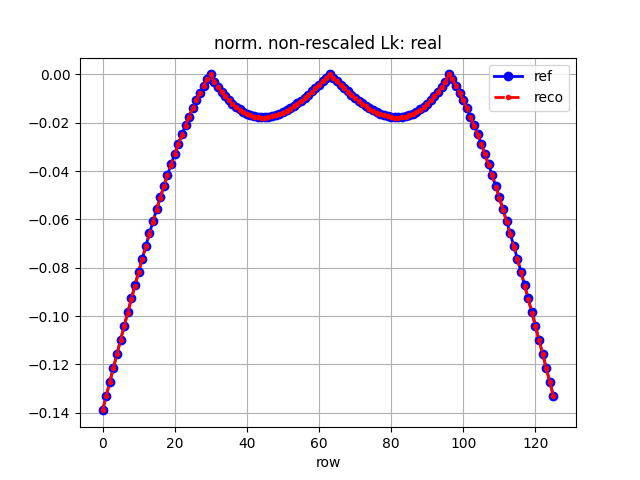

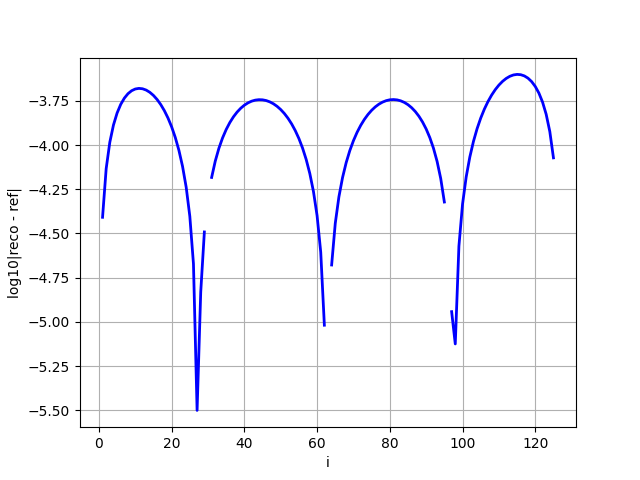

In [41]:
# ***********************************************************************************************************
# ***********************************************************************************************************
# ***********************************************************************************************************
# ---------------------------------------------------------------------------------------
# --- Compare with the QuCF computations ---
# ---------------------------------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(qucf_r)
mix.reload_module(kvn)
def compare_to_qucf(sel_diag, flag_save):
    name_qucf_project = "be"
    name_qucf_hdf5 = name_qucf_project + "_OUTPUT.hdf5"

    # --- Get reference diagonals (w.r.t x, not asin(x)) ---
    if sel_diag == "D":
        name_qsvt = "D"
        y_ref, _ = mix.get_diag(Bk_.real, i_shift = 0)
    if sel_diag == "Rk":
        name_qsvt = "Rk"
        y_ref, _ = mix.get_diag(Bk_.real, i_shift = 1)
    if sel_diag == "Lk":
        name_qsvt = "Rk"
        y_ref, _ = mix.get_diag(Bk_.real, i_shift = -1)
    if sel_diag == "Ra":
        name_qsvt = "Ra"
        y_ref, _ = mix.get_diag(Ba_.imag, i_shift = 1)
    if sel_diag == "La":
        name_qsvt = "Ra"
        y_ref, _ = mix.get_diag(Ba_.imag, i_shift = -1)

    # --- Read the matrix from QuCF simulations ---
    dd_loc = qucf_r.read_matrix_sparse(path_qucf_, name_qucf_hdf5) 

    # --- Read the QSVT norm. factor ---
    om = mse.MeasOracle__()
    om.path_  = path_qucf_
    om.pname_ = name_qucf_project
    om.open()
    om.read_qsvt()
    coef_norm = om.dd_[name_qsvt]["rescaling_factor"]
    print("QSVT rescaling factor (for sum {:s}): {:0.3e}".format(sel_diag, coef_norm))
    
    # The matrix computed by the BE oracle:
    B_rec = dd_loc["A"].form_dense_matrix() / coef_norm
    we = Nx_ - 1
    if sel_diag == "D":
        we = Nx_
        y_reco, _ = mix.get_diag(B_rec.real, i_shift = 0)
        str_comp = "real"
    if sel_diag == "Rk":
        y_reco, _ = mix.get_diag(B_rec.real, i_shift = 1)
        str_comp = "real"
    if sel_diag == "Lk":
        y_reco, _ = mix.get_diag(B_rec.real, i_shift = -1)
        str_comp = "real"
    if sel_diag == "Ra":
        y_reco, _ = mix.get_diag(B_rec.imag, i_shift = 1)
        str_comp = "imag"
    if sel_diag == "La":
        y_reco, _ = mix.get_diag(B_rec.imag, i_shift = -1)
        str_comp = "imag"

    # --- !!! Attention !!!: set bondaries to avoid considering edges ---
    # wb, we = 0, we # should be used when edges are corrected
    # wb, we = 1, we # problem in the left edge
    wb, we = 0, we - 1 # problem in the right edge

    row_work = range(wb, we)



    y_reco *= np.max(np.abs(y_ref[wb:we])) / np.max(np.abs(y_reco[wb:we]))
    
    # --- Error ---
    err_abs = np.zeros(len(row_work))
    log_err = np.zeros(len(row_work))
    for ii in range(wb, we):
        temp = np.abs(y_reco[ii] - y_ref[ii])
        if temp <= 1e-16:
            temp = 0
        err_abs[ii-wb] = temp
        log_err[ii-wb] = np.log10(temp)

    print("\nmax. |err|: {:0.3e}".format(np.max(err_abs)))

    # --- PLOTTING main diagonal ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(row_work,  y_ref[wb:we],  '-b', marker='o', linewidth = 2, label = "ref")
    ax.plot(row_work, y_reco[wb:we], '--r', marker='.', linewidth = 2, label = "reco")
    plt.xlabel('row')
    plt.title("norm. non-rescaled " + sel_diag + ": " + str_comp)
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- PLOTTING error ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(row_work, log_err, color="b", linewidth = 2, linestyle='-')
    plt.xlabel('i')
    plt.ylabel("log10|reco - ref|")
    plt.grid(True)
    plt.show() 

    def temp():
        # # --- Compare BE oracle matrix with the encoded matrix ---
        # mix.compare_matrices_dense(B_ref_, B_rec, flag_return_err=True)

        # # --- Save data ---
        # if flag_save:

        #     # - original profile -
        #     fname = "{:s}_REF.dat".format(key_diag_)
        #     mix.save_dat_plot_1d_file(path_save_ + "/" + fname, range_x, diag_ref)

        #     # - reconstructed profile -
        #     fname = "{:s}_REC.dat".format(key_diag_)
        #     mix.save_dat_plot_1d_file(path_save_ + "/" + fname, range_x, diag_rec)

        #     # - errors -
        #     fname = "{:s}_LOG_ERROR.dat".format(key_diag_)
        #     mix.save_dat_plot_1d_file(path_save_ + "/" + fname, range_x, log_err)
        return
    return
# ----------------------------------------------------------------------
compare_to_qucf(
    sel_diag = "Lk", # D, Rk, Lk, or Ra, La
    flag_save = False
)

In [54]:
# --------------------------------------------------------------------------------------
# --- Correcting edge elements ---
# --------------------------------------------------------------------------------------
mix.reload_module(mse)

# -----------------------------------------------------------------------------
# To compute the correcting angles, do the following in the kvn.oracle file:
# > comment oracle OM and OF_BACKWARD 
# > compute the output states for boundary values, e.g. by setting 
#         INPUT_STATE  rx  0
#         INPUT_STATE  rx -1
#   in MAIN_CIRCUIT, and using
#         sel_compute_output all
#   in OPTIONS
# -----------------------------------------------------------------------------
def correcting_edge(sel_diag):
    if sel_diag == "Ra":
        input_rx, ax_state,       coef_edge, coef_bulk = \
               0,        0,   1./np.sqrt(2),       0.5          
    if sel_diag == "La":
        input_rx, ax_state,       coef_edge, coef_bulk = \
           Nx_-1,        1,   1./np.sqrt(2),       0.5          
        
    if sel_diag == "Rk":
        input_rx, ax_state,       coef_edge, coef_bulk = \
               0,        3,   1./np.sqrt(8),      0.25      
    if sel_diag == "Lk":
        input_rx, ax_state,       coef_edge, coef_bulk = \
           Nx_-1,        2,   1./np.sqrt(8),      0.25      

    # --- Reading QuCF simulations ---
    om = mse.MeasOracle__(True)
    om.path_ = path_qucf_
    om.pname_ = "be"
    om.open()
    om.read_qsvt()

    if input_rx > 0:
        om.set_work_states(1)  # consider INPUT_STATE  rx -1
    else:
        om.set_work_states(0)  # consider INPUT_STATE  rx  0

    # print()
    # print("input_rx_: ", input_rx_)
    # print("ax: ", ax_state_) 
    # print("coef_resc_: ", coef_resc_)
    # print("coef_edge: ", coef_edge)
    # print()  

    # --- Current value ---
    curr_values = om.get_var_x(
        {"rx": input_rx, "ax": ax_state, "acom": 0},
        "ae"
    )
    curr_values = curr_values[0:-1:2]  # take only states where ae[0] = 0
    
    print("\nnon-corrected states ")
    print("{:20.3e}".format(curr_values[0]))
    print("{:20.3e}".format(curr_values[1]))


    # --- Required value (with correct rescaling) ---
    goal_value = curr_values[0] * coef_bulk / coef_edge

    # --- Compute the correction angles ---
    ayc, azc = mix.find_correcting_angles_for_Rc_FLOAT(
        goal_value, 
        curr_values
    )
    print()
    print("ay_corr_{:s} \t{:0.12e}".format(sel_diag , ayc))
    print("az_corr_{:s} \t{:0.12e}".format(sel_diag, azc))

    # ay2 = 2. * np.arccos(goal_value.imag/curr_values[0].imag)
    # print("v2: ay: {:0.12e}".format(ay2))

    return
# -----------------------------------------------
correcting_edge(sel_diag = "Lk")

Reading the file ../QuCF/simulations/LCHS/KvN/BE-2//be_OUTPUT.hdf5...
Name of the simulation is be
Simulation has been performed  06-25-2024 17:22:10

non-corrected states 
-8.697e-02+9.329e-15j
6.726e-14-6.745e-01j

ay_corr_Lk 	1.203048325349e-01
az_corr_Lk 	-8.739134046913e-01



--- Reading D-matrices for BE oracles of the matrix Ah for various nx.
Reading the matrix from: Dk-n4.hdf5
from the path: ../QuCF/simulations/LCHS/KvN/BE-2/UD/
date of the simulation:  06-11-2024 17:59:32
matrix name:  U_BE_kmax
N = 16

--- Reading D-matrices for BE oracles of the matrix Aa for various nx.
Reading the matrix from: Da-n4.hdf5
from the path: ../QuCF/simulations/LCHS/KvN/BE-2/UD/
date of the simulation:  06-11-2024 18:07:14
matrix name:  U_BE_a
N = 16

--- Reading D-matrices for BE oracles of the matrix Ah for various nx.
Reading the matrix from: Dk-n7.hdf5
from the path: ../QuCF/simulations/LCHS/KvN/BE-2/UD/
date of the simulation:  06-11-2024 17:57:31
matrix name:  U_BE_kmax
N = 128

--- Reading D-matrices for BE oracles of the matrix Aa for various nx.
Reading the matrix from: Da-n7.hdf5
from the path: ../QuCF/simulations/LCHS/KvN/BE-2/UD/
date of the simulation:  06-11-2024 18:07:44
matrix name:  U_BE_a
N = 128


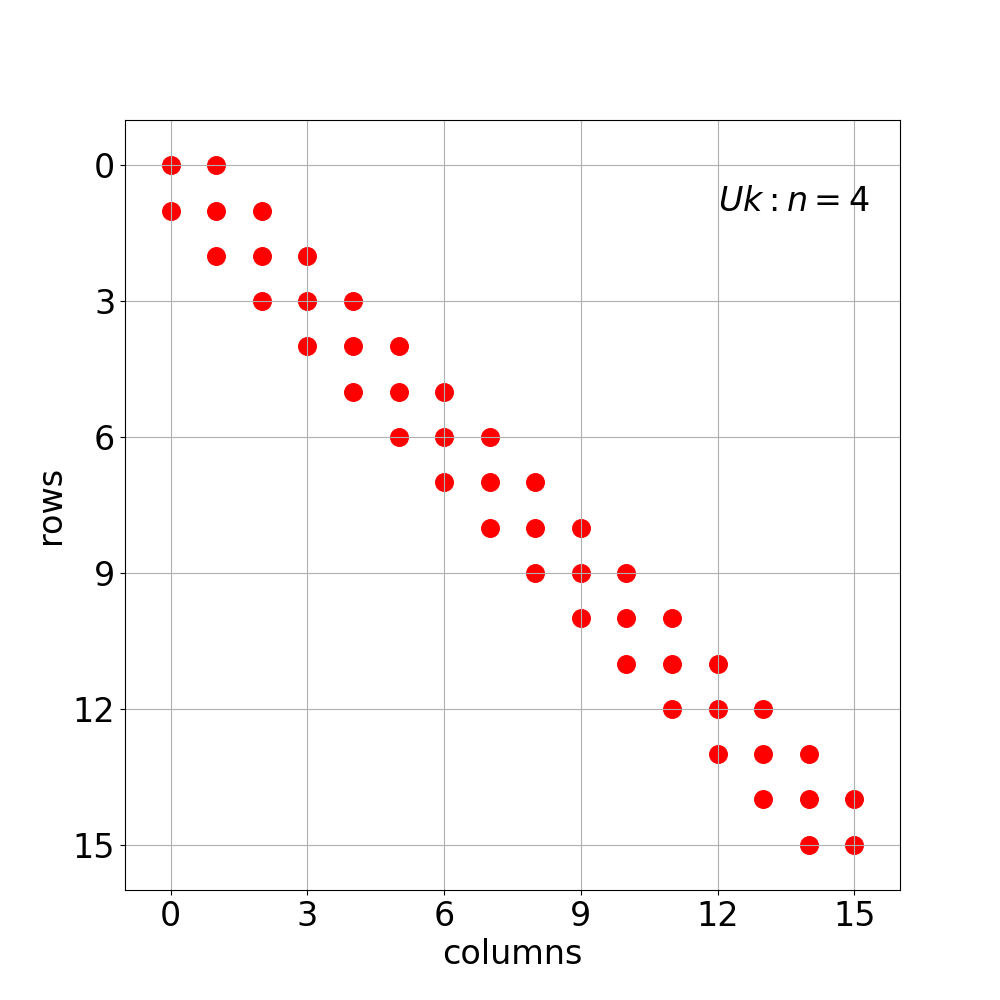

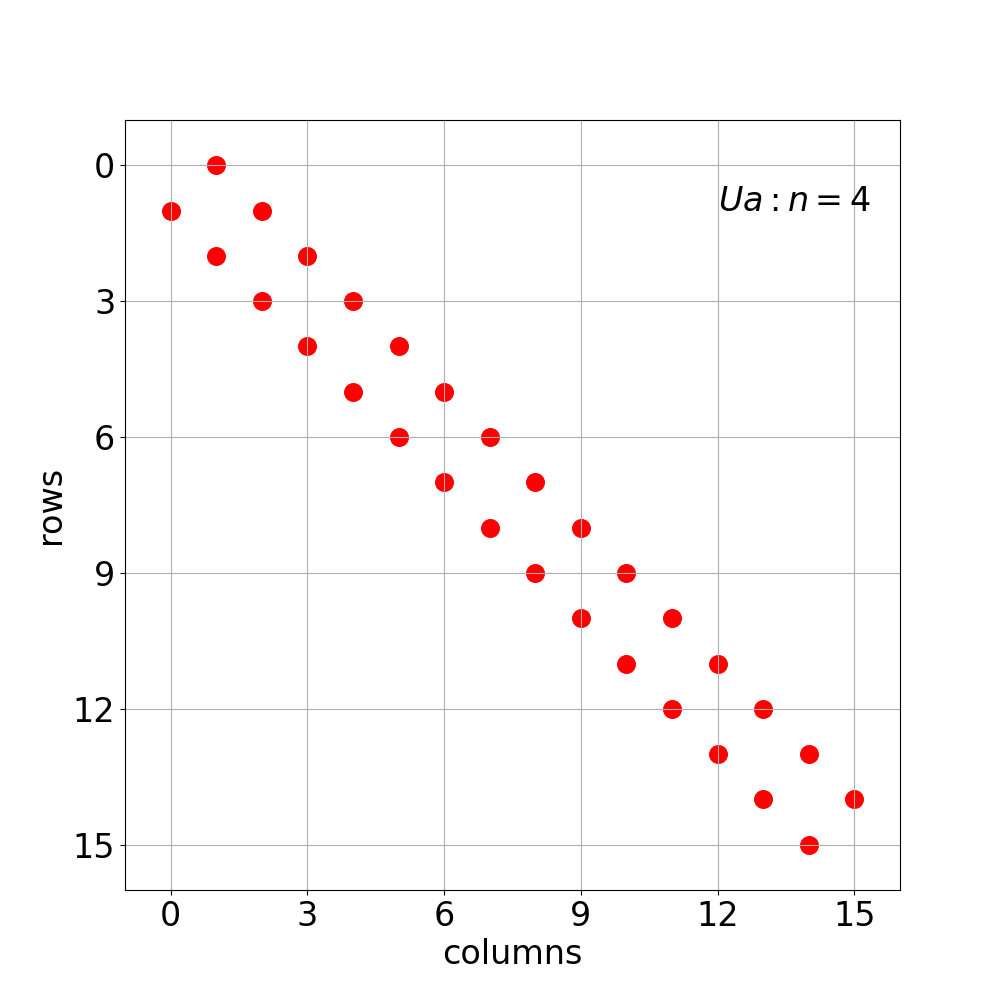

--- Elements in Dk in the diagonal 1 ---

 0.354  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250 

 0.354  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.

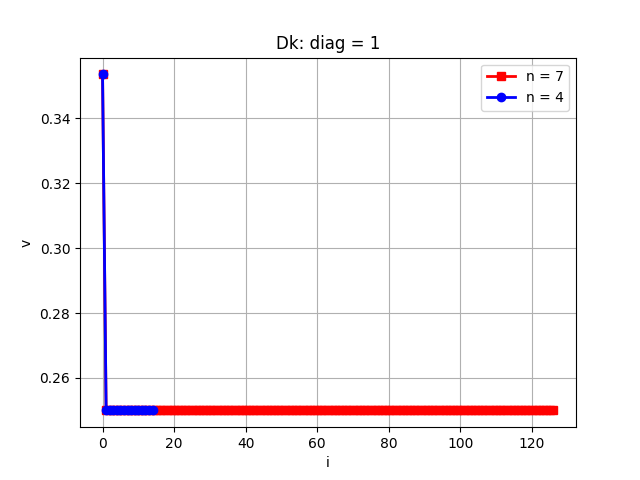

In [41]:
# ***********************************************************************************************************
# ***********************************************************************************************************
# ***********************************************************************************************************
# -------------------------------------------------------------------------
# --- Read D-matrices computed by the QuCF ---
# -------------------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(qucf_r)
mix.reload_module(kvn)
def reading_UD_matrices():
    path_D = path_qucf_ + "UD/"
    diff_n = [4, 7]
    dds_k = []
    dds_a = []
    for ii in range(len(diff_n)):
        print()
        print("--- Reading D-matrices for BE oracles of the matrix Ah for various nx.")
        fname_loc = "Dk-n{:d}.hdf5".format(diff_n[ii])
        dd_loc    = qucf_r.read_matrix_sparse(path_D, fname_loc) 
        dds_k.append(dd_loc)

        print()
        print("--- Reading D-matrices for BE oracles of the matrix Aa for various nx.")
        fname_loc = "Da-n{:d}.hdf5".format(diff_n[ii])
        dd_loc    = qucf_r.read_matrix_sparse(path_D, fname_loc) 
        dds_a.append(dd_loc)

    # --- Plot structures of D-matrices computed by the QuCF ---
    id_plot = 0
    dds_k[id_plot]["A"].plot_structure("Uk: n={:d}".format(diff_n[id_plot]))
    dds_a[id_plot]["A"].plot_structure("Ua: n={:d}".format(diff_n[id_plot]))
    return diff_n, dds_k, dds_a
# -----------------------------------------------------------------------------------
def print_plot_D_elements(id_shift, dds_print, str_matrix, flag_plot = True):
    colors = ["b", "r", "g"]
    markers = ["o", "s", "*"]

    # --- Printing ---
    print("--- Elements in {:s} in the diagonal {:d} ---".format(str_matrix, id_shift))
    print()
    for ii in range(len(diff_n)):
        mix.print_array(
            kvn.get_diag(dds_print[ii]["A"].form_dense_matrix(), id_shift)[0].real,
            n_in_row = 8,
            ff=[6, 3, "f"]
        )
        print()

    # --- Plotting ---
    if flag_plot:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        for i1 in range(len(diff_n)):
            ii = len(diff_n) - i1 - 1
            n1 = diff_n[ii]
            ax.plot(
                np.array(range((1<<n1) - np.abs(id_shift))), 
                kvn.get_diag(dds_print[ii]["A"].form_dense_matrix(), id_shift)[0].real, 
                color=colors[ii], linewidth = 2, linestyle='-', marker = markers[ii],
                label = "n = {:d}".format(n1)
            )
        plt.xlabel('i')
        plt.ylabel("v")
        plt.title(str_matrix + ": diag = {:d}".format(id_shift))
        plt.legend()
        plt.grid(True)
        plt.show() 
# -----------------------------------------------------------------------------------
# ---
diff_n, dds_k, dds_a = reading_UD_matrices()

# ---
id_diag = 1
print_plot_D_elements(id_diag, list(dds_k), "Dk")
# print_plot_D_elements(id_diag, list(dds_a), "Da")
del id_diag

Reading the matrix from: be_OUTPUT.hdf5
from the path: ../QuCF/simulations/LCHS/KvN/BE-2/
date of the simulation:  06-25-2024 17:15:47
matrix name:  U_BE_k
N = 128


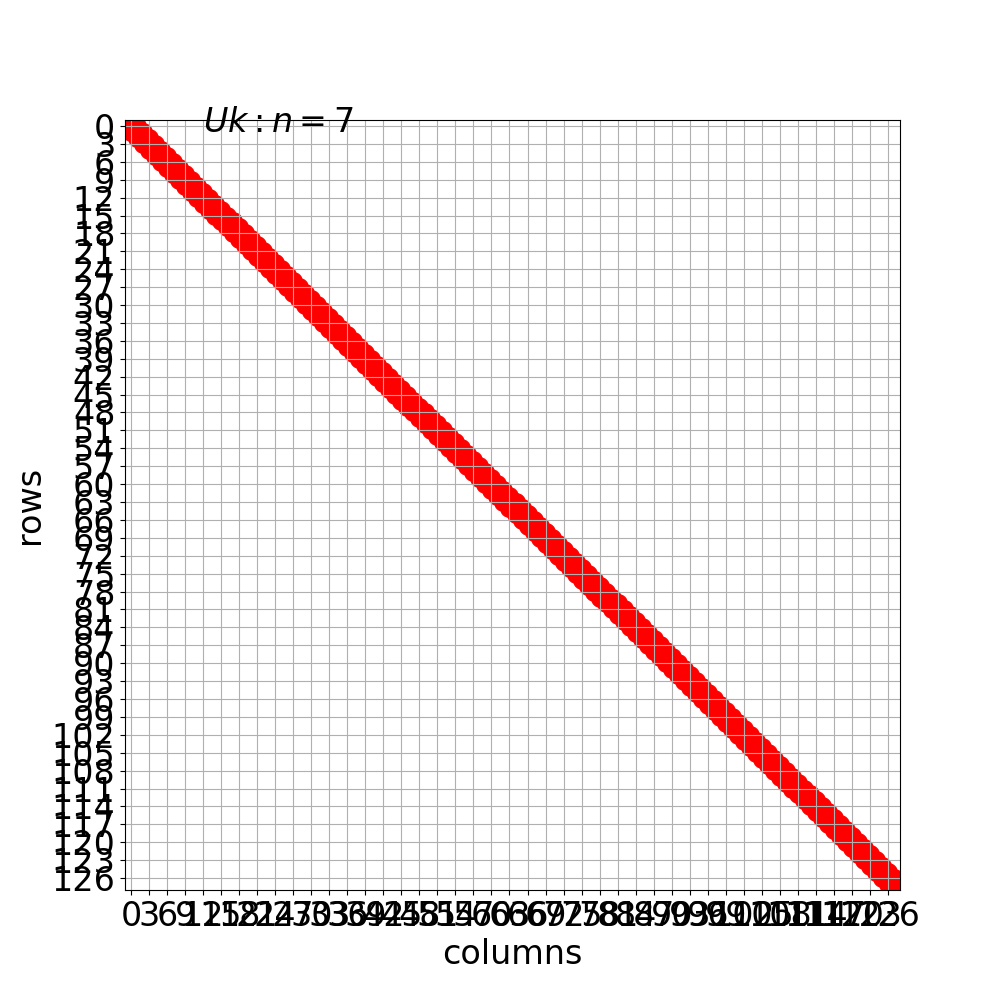

--- Elements in Dk in the diagonal 1 ---

 0.354  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250  0.250 
 0.250  0.250  0.250  0.250  0.250  0.250  0.250 



In [48]:
# ***********************************************************************************************************
# ***********************************************************************************************************
# ***********************************************************************************************************
# -------------------------------------------------------------------------
# --- Read the current D-matrix computed by the QuCF ---
# -------------------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(qucf_r)
mix.reload_module(kvn)
def reading_UD_matrices():
    dd_loc = qucf_r.read_matrix_sparse(path_qucf_, "be_OUTPUT.hdf5") 
    dd_loc["A"].plot_structure("Uk: n={:d}".format(nx_))
    return dd_loc
# -----------------------------------------------------------------------------------
def print_plot_D_elements(id_diag, dd, str_matrix):
    colors = ["b", "r", "g"]
    markers = ["o", "s", "*"]

    # --- Printing ---
    print("--- Elements in {:s} in the diagonal {:d} ---".format(str_matrix, id_diag))
    print()
    mix.print_array(
        kvn.get_diag(dd["A"].form_dense_matrix(), id_diag)[0].real,
        n_in_row = 8,
        ff=[6, 3, "f"]
    )
    print()
# -----------------------------------------------------------------------------------
print_plot_D_elements(
    id_diag = 1,
    dd = reading_UD_matrices(), 
    str_matrix = "Dk"
)